In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from sklearn.linear_model import Lasso
import dalex as dx
from dalex.instance_level import CeterisParibus

# MEPS Data

In [2]:
# Loading data and data processing
print("Data head")
df = pd.read_csv("MEPS_data_preprocessed.csv")
df

Data head


PANEL  REGION  AGE31X  GENDER  RACE3  MARRY31X  EDRECODE  FTSTU31X  \
0         19       2      52     0.0    0.0         5        13        -1   
1         19       2      55     1.0    0.0         3        14        -1   
2         19       2      22     1.0    0.0         5        13         3   
3         19       2       2     0.0    0.0         6        -1        -1   
4         19       3      25     1.0    0.0         1        14        -1   
...      ...     ...     ...     ...    ...       ...       ...       ...   
18345     20       2      36     0.0    0.0         5        15        -1   
18346     20       2      78     1.0    0.0         2        13        -1   
18347     20       2      43     0.0    1.0         5        13        -1   
18348     20       4      54     0.0    0.0         1         2        -1   
18349     20       2      30     1.0    0.0         5        14        -1   

       ACTDTY31  HONRDC31  ...  PCS42  MCS42  K6SUM42  PHQ242  EMPST31  \
0             2         2  ...  25.93  58.47        3       0        4   
1             2         2  ...  20.42  26.57       17       6        4   
2             2         2  ...  53.12  50.33        7       0        1   
3             3         3  ...  -1.00  -1.00       -1      -1       -1   
4             2         2  ...  59.89  45.91        9       2        1   
...         ...       ...  ...    ...    ...      ...     ...      ...   
18345         2         2  ...  53.46  57.33        2       0        1   
18346         4         2  ...  45.22  54.19        2       2        4   
18347         2         2  ...  53.46  57.33        2       0        1   
18348         2         2  ...  -1.00  -1.00       -1      -1        1   
18349         2         2  ...  44.32  28.41        7       2        1   

       POVCAT15  INSCOV15  INCOME_M  HEALTHEXP      PERSONWT  
0             1         2   11390.0      46612  21854.981705  
1             3         2   11390.0       9207  18169.604822  
2             2         2   18000.0        808  17191.832515  
3             2         2     385.0       2721  20261.485463  
4             3         1    3700.0       1573   7620.222014  
...         ...       ...       ...        ...           ...  
18345         5         1   51200.0          0  18763.253623  
18346         4         2       0.0      10088   9555.437410  
18347         4         1   37000.0          0  10677.003212  
18348         5         1   96442.0      31091  10681.541929  
18349         3         1   20562.0       2056  11481.496934  

[18350 rows x 46 columns]

In [3]:
# Data description
print("Data description\n")
description = df.describe()
for d in description:
    print(description[d], '\n')

Data description

count    18350.000000
mean        19.529264
std          0.499156
min         19.000000
25%         19.000000
50%         20.000000
75%         20.000000
max         20.000000
Name: PANEL, dtype: float64 

count    18350.000000
mean         2.607466
std          0.942848
min          1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          4.000000
Name: REGION, dtype: float64 

count    18350.000000
mean        38.746649
std         23.020492
min          0.000000
25%         19.000000
50%         38.500000
75%         57.000000
max         85.000000
Name: AGE31X, dtype: float64 

count    18350.000000
mean         0.521526
std          0.499550
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: GENDER, dtype: float64 

count    18350.000000
mean         0.338147
std          0.473092
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
m

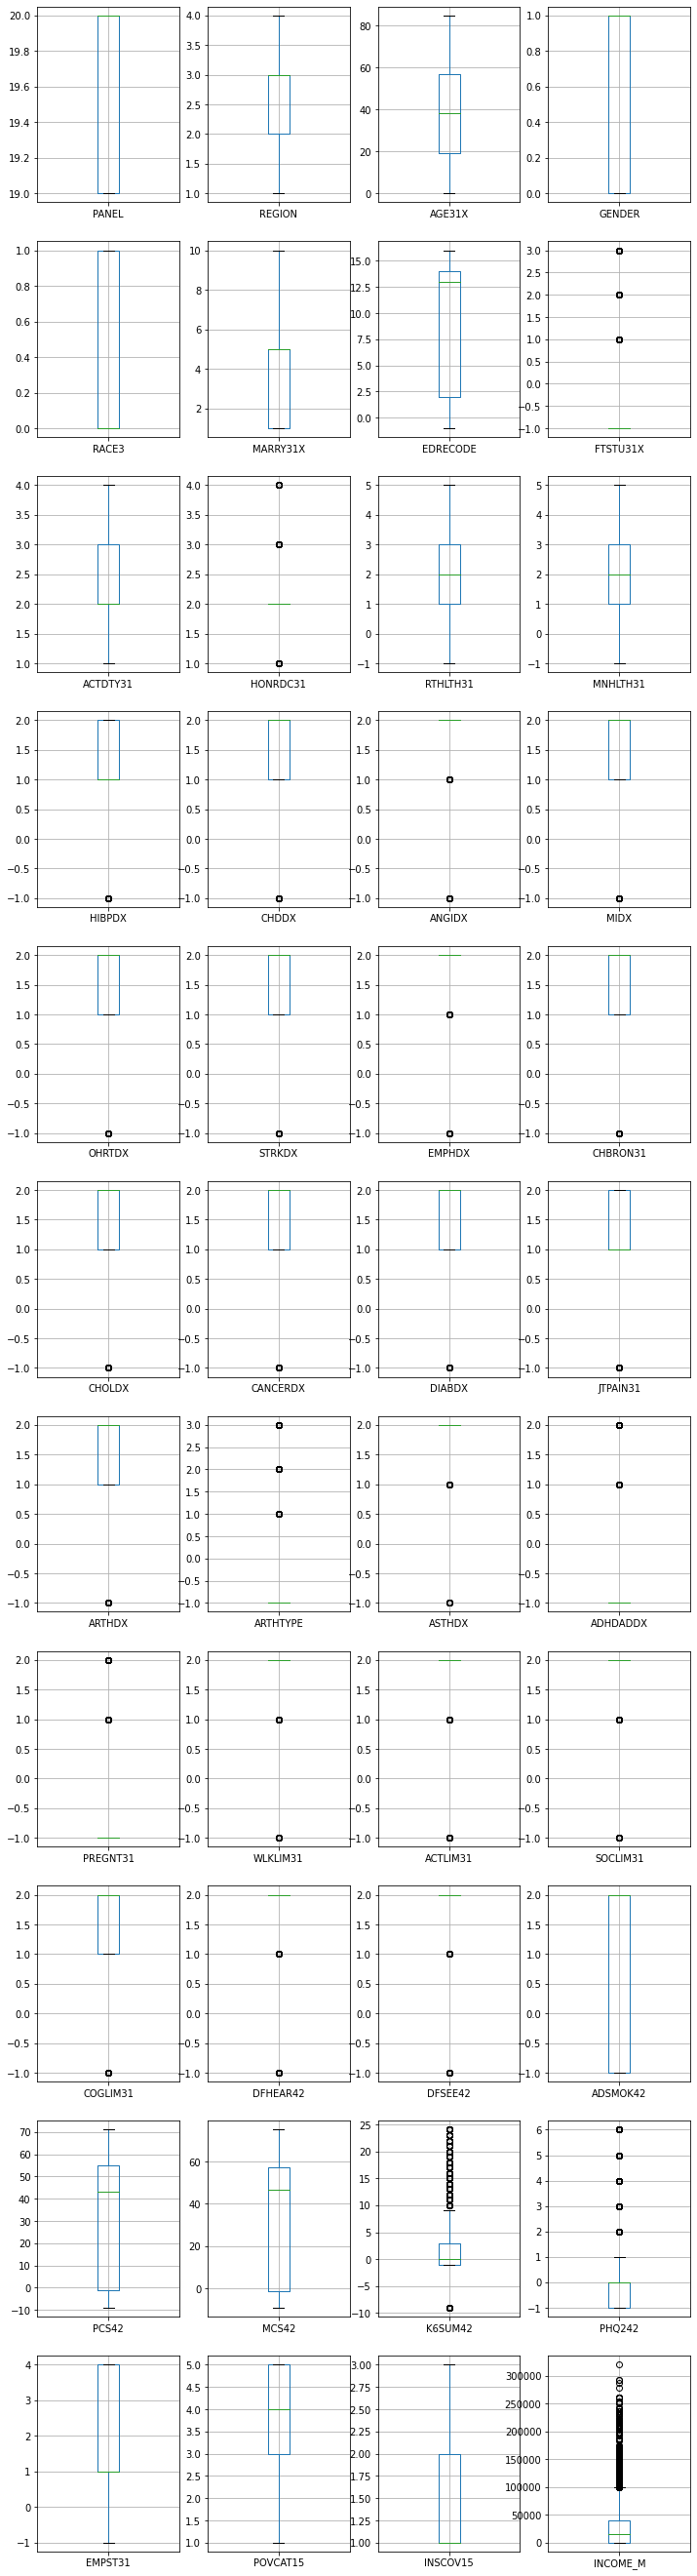

In [4]:
# Boxplots of variables
fig, axes = plt.subplots(11, 4, figsize = (12, 48))

i = 0
for triaxis in axes:
    for axis in triaxis:
        df.boxplot(column = df.columns[i], ax = axis)
        i = i+1

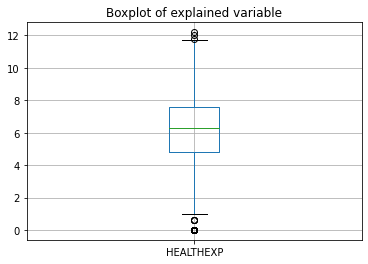

In [41]:
# Y variable
df.boxplot(column="HEALTHEXP", return_type='axes')
plt.title( "Boxplot of explained variable" )
plt.suptitle('') 
plt.show()

#### Data has a long taile,  hence logarithmic (base 3) transformation of explained variable (HEALTHEXP). 

In [6]:
# Data has a long tail, hence logarithmic transformation of Y
val = df['HEALTHEXP'].values
df['HEALTHEXP'] = np.array([0 if v == 0 else np.log(v) / np.log(3) for v in val])


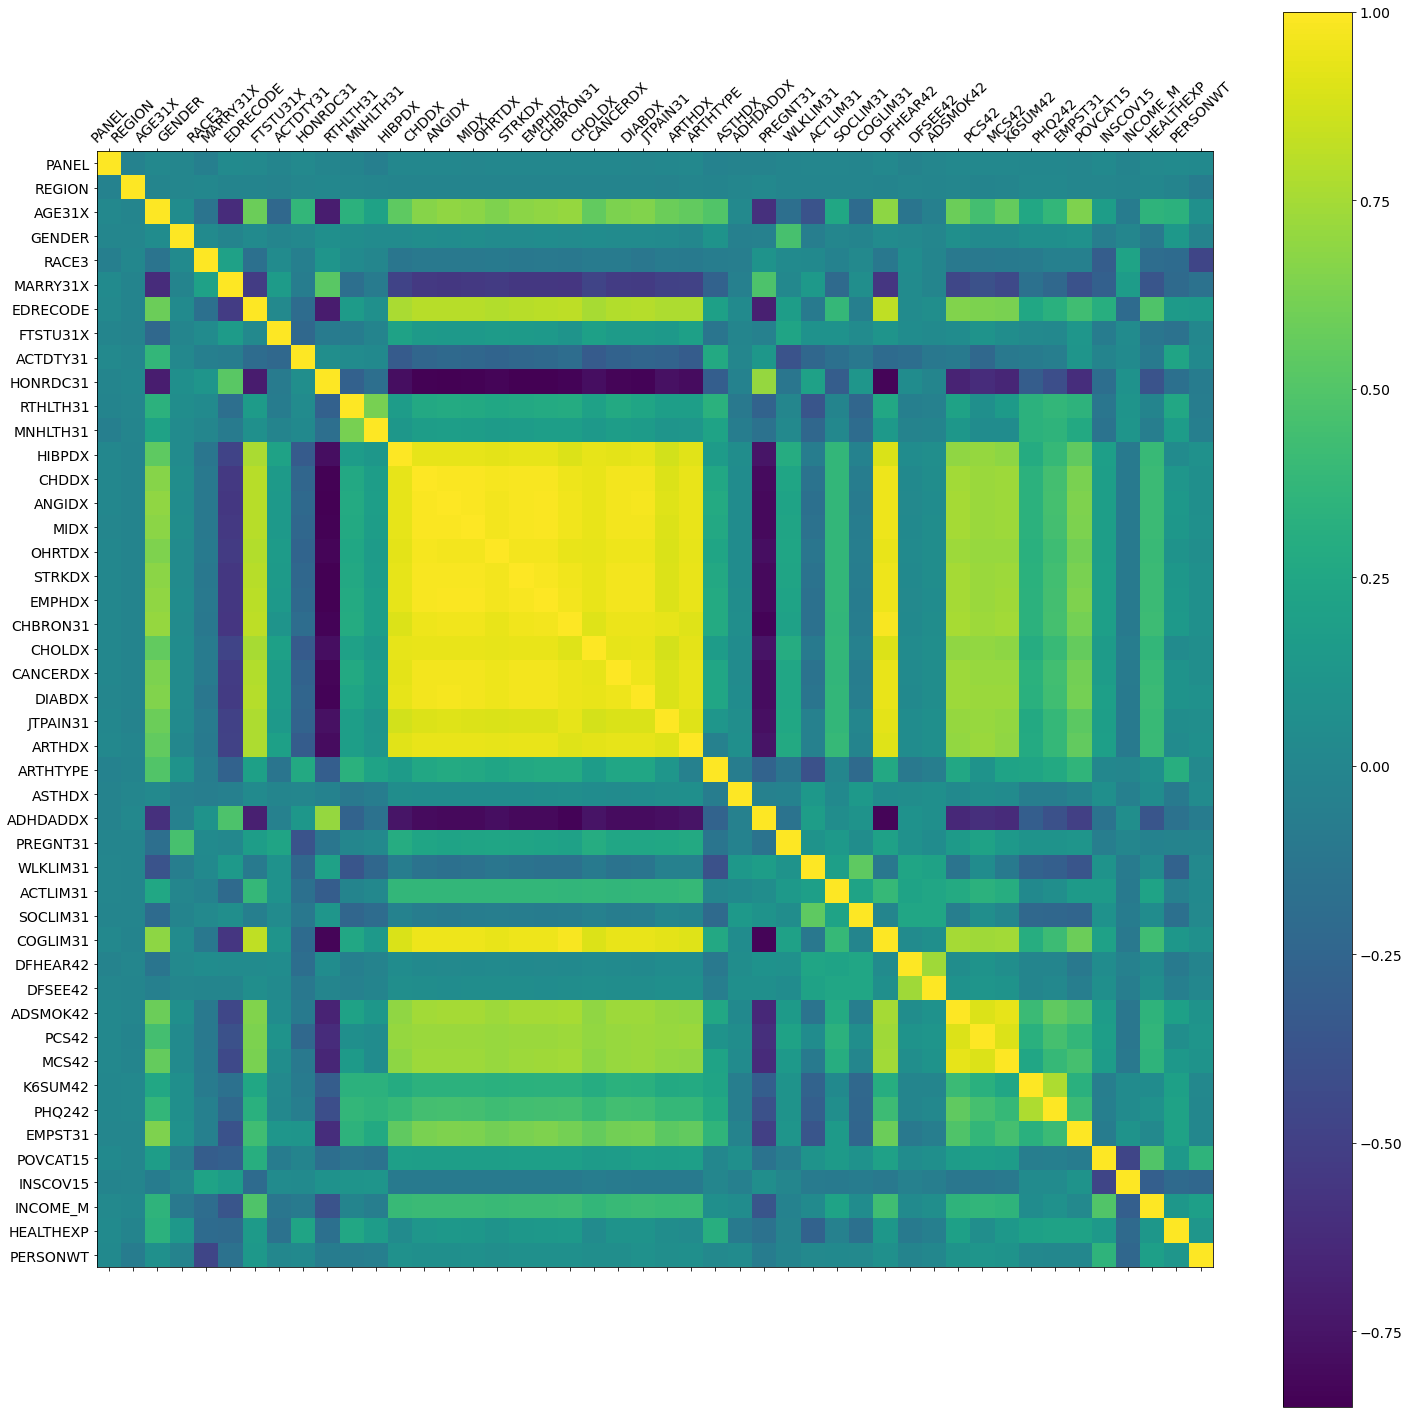

In [7]:
# Correlation matrix
f = plt.figure(figsize=(25, 25))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [8]:
# Dropping the panel number (19 or 20, not meant to be predictive)
df.drop(columns = ['PANEL'], inplace=True)

In [38]:
# # One hot encoding of variables
cat_inx = df.nunique()[df.nunique() == 3 ].index.tolist() # only vairables with values {-1, 1, 2} which means "inapplicable, yes, no"
cat_inx.remove('INSCOV15')
print(f"Categorical variables:\n {cat_inx}")

Categorical variables:
 ['HIBPDX', 'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX', 'STRKDX', 'EMPHDX', 'CHBRON31', 'CHOLDX', 'CANCERDX', 'DIABDX', 'JTPAIN31', 'ARTHDX', 'ASTHDX', 'ADHDADDX', 'PREGNT31', 'WLKLIM31', 'ACTLIM31', 'SOCLIM31', 'COGLIM31', 'DFHEAR42', 'DFSEE42', 'ADSMOK42']


In [10]:
# Dividing data
x_train, x_test, y_train, y_test = train_test_split(df.drop(["HEALTHEXP"], axis = 1),
                                                    df["HEALTHEXP"], test_size=0.2, random_state=123)

# Model - XGB and Linear

In [11]:
def get_model_results(model_name: str, pred_train, y_train, pred_test, y_test, print_res):
    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
    r_2_train = r2_score(y_train, pred_train)
    rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
    r_2_test = r2_score(y_test, pred_test)
    mae_test = mean_absolute_error(y_test, pred_test)
    mae_train = mean_absolute_error(y_train, pred_train)

    if print_res:
        print(f"{model_name} results:")
        print(f"training rmse: {rmse_train}\ntraining r2: {r_2_train}\ntraining mae: {mae_train}")
        print(f"test rmse: {rmse_test}\ntest r2: {r_2_test}\ntest mae: {mae_test}\n")

    return [rmse_train, rmse_test,  r_2_train, r_2_test,  mae_train,  mae_test]


In [12]:
# XGB model
n_es = [10*i for i in range(3,15)]
depth = [i for i in range(3, 12)]

feature_names = list(x_train)

col_names_res_xgb = ['n', 'd', 'rmse_train', 'rmse_test', 'r_2_train',  'r_2_test', 'mae_train', 'mae_test']
df_res_xgb = pd.DataFrame(columns=col_names_res_xgb)

def xgb_train_and_predict(depth, n_est):
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',
                                  colsample_bytree = 0.4,
                                  learning_rate = 0.2,
                                  max_depth = d,
                                  alpha = 15,
                                  n_estimators = n,
                                  feature_names=feature_names
                                  )
    xg_reg.fit(x_train, y_train)
    predictions_train = xg_reg.predict(x_train)
    predictions_test = xg_reg.predict(x_test)
    return xg_reg, predictions_train, predictions_test

In [13]:
# XGB with final parameters
d = 6
n = 60
xg_reg, predictions_train, predictions_test = xgb_train_and_predict(d, n)
xgb_res = get_model_results(f"XGB  ", predictions_train, y_train, predictions_test, y_test, True)

XGB   results:
training rmse: 1.977698616711458
training r2: 0.48684795508177536
training mae: 1.4688560597283682
test rmse: 2.1665237944616744
test r2: 0.37313414322890304
test mae: 1.6149617997637638



In [14]:
# Linear Model with lasso

l_reg = Lasso(alpha=0.5, max_iter=10e5)
l_reg.fit(x_train, y_train)
pred_lr_test = l_reg.predict(x_test)
pred_lr_train = l_reg.predict(x_train)

lasso_res = get_model_results("Lasso Regression", pred_lr_train, y_train, pred_lr_test, y_test, True)

Lasso Regression results:
training rmse: 2.530774417382313
training r2: 0.15970318823228213
training mae: 1.9013310836499353
test rmse: 2.4984493904113023
test r2: 0.1663403093243384
test mae: 1.862761172732874



# Explaining model

## Ceteris Paribus explanations for XGB

In [33]:
exp_xgb = dx.Explainer(xg_reg, x_train, y_train, label = "MEPS")

Preparation of a new explainer is initiated

  -> label             : MEPS
  -> data              : 14680 rows 44 cols
  -> target variable   : Argument 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 14680 values
  -> predict function  : <function yhat_default at 0x7fb477ce7700> will be used
  -> predicted values  : min = -0.8554313, mean = 5.7083073, max = 10.244568
  -> residual function : difference between y and yhat
  -> residuals         : min = -7.963533878326416, mean = 0.0019564959693102344, max = 6.395156118316233
  -> model_info        : package xgboost

A new explainer has been created!


In [16]:
def explain_with_cp(exp: dx.Explainer, index):
    cp_res = exp.predict_profile(pd.DataFrame(x_test.iloc[[index]]))
    cp_res.result.head()
    cp_res.plot()

In [29]:
k = 3639
print("Patien no: ", k , " , prediction value: ", predictions_test[k], " true value: ",  y_test.iloc[[k]].values, "\n\n")


explain_with_cp(exp_xgb, k)

Calculating ceteris paribus!:  25%|██▌       | 11/44 [00:00<00:00, 109.36it/s]

Patien no:  3639  , prediction value:  6.5051827  true value:  [6.50884896] 




Calculating ceteris paribus!: 100%|██████████| 44/44 [00:00<00:00, 113.31it/s]


### 3
#### Patient 3639 has rather higher prediction since he has joint pain (JTPAIN31), asthma diagnosis (ASTHDX), low overall ratings of feelings (PHQ242) and high income (POVCAT15) and has a private insurance coverage (INSCOV15). Lack of other positive diagnoses decreases the prediction.

In [24]:
k = 975
print("Patien no: ", k , " , prediction value: ", predictions_test[k], " true value: ",  y_test.iloc[[k]].values, "\n\n")


explain_with_cp(exp_xgb, k)

Calculating ceteris paribus!:  18%|█▊        | 8/44 [00:00<00:00, 79.77it/s]

Patien no:  975  , prediction value:  0.00083711743  true value:  [0.] 




Calculating ceteris paribus!: 100%|██████████| 44/44 [00:00<00:00, 106.24it/s]


#### Patient number 975 has a zero cost prediction since he is not diagnosed with any disease. Each positive diagnosis would increase his payment.

In [28]:
k = 896
print("Patien no: ", k , " , prediction value: ", predictions_test[k], " true value: ",  y_test.iloc[[k]].values, "\n\n")


explain_with_cp(exp_xgb, k)

Calculating ceteris paribus!:  25%|██▌       | 11/44 [00:00<00:00, 104.00it/s]

Patien no:  896  , prediction value:  8.826893  true value:  [8.82324185] 




Calculating ceteris paribus!: 100%|██████████| 44/44 [00:00<00:00, 117.89it/s]


#### Patient number 896 has a high prediction since he is tested positive on high blood pressure, diabetes, asthma, has limitations in physical as well as in work/house/school functioning. He has rather low value of physical summary.
### 4 
#### Patient 896 and patient 975 are good examples. Change in value of HIBDX (high blood diagnosis), ASTHDX (asthma diagnosis), WLKLIM31(limitation in physical functioning ) lowers the prediction for patient 896 and increases the prediction for the patient 975. The result intuitively make sense since it states that the more positive diagnosis the higher prediction.¶



## Comparing CP  explanations for XGB with Lasso Regression

In [32]:
print("Creating explainer for linear model")
exp_lasso = dx.Explainer(l_reg, x_train, y_train, label = "MEPS")

Creating explainer for linear model
Preparation of a new explainer is initiated

  -> label             : MEPS
  -> data              : 14680 rows 44 cols
  -> target variable   : Argument 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 14680 values
  -> predict function  : <function yhat_default at 0x7fb477ce7700> will be used
  -> predicted values  : min = 3.251906166715444, mean = 5.710264253185743, max = 9.922703669439233
  -> residual function : difference between y and yhat
  -> residuals         : min = -9.922703669439233, mean = -1.8586403987185183e-16, max = 6.282237531056754
  -> model_info        : package sklearn

A new explainer has been created!


In [35]:
k = 704
print("Patien no: ", k , " , prediction value: ", predictions_test[k], " true value: ",  y_test.iloc[[k]].values, "\n\n")


explain_with_cp(exp_xgb, k)

Calculating ceteris paribus!:  32%|███▏      | 14/44 [00:00<00:00, 133.59it/s]

Patien no:  704  , prediction value:  8.046038  true value:  [8.04268481] 




Calculating ceteris paribus!: 100%|██████████| 44/44 [00:00<00:00, 125.32it/s]


### XGB explanation
#### Patient 704 is a 59 years old femmel. Her cost is predicted to be high due to her age and not being a student (which suggest correlation), high blood pressure diagnosis (HIBDX), coronary heart disease (CHDDX) with other heart disease (OHRTDX),  arthritis diagnosis, limitations in physical functioning (WLKLIM31), social limitations (SOCLIM). Not being diagnosed with high cholesterol (CHOLDX) lowers 3 times the costs. Not being tested positive for cancer, diabetes also lowers the cost.

In [37]:
print("Patien no: ", k , " , prediction value: ", pred_lr_test[k], " true value: ",  y_test.iloc[[k]].values, "\n\n")

explain_with_cp(exp_lasso, k)


Calculating ceteris paribus!:  39%|███▊      | 17/44 [00:00<00:00, 161.09it/s]

Patien no:  704  , prediction value:  7.507052624767924  true value:  [8.04268481] 




Calculating ceteris paribus!: 100%|██████████| 44/44 [00:00<00:00, 173.08it/s]


### Lasso explanation
#### The same patient as above (704). Linear lasso model  predicted 1.5 lower health expenses. The linear model did not focus on categorical variables. The cost was high due to patient age, overall ratings of feelings.
### 5
#### It is easier to explain a more complex model with CP in this case and the explanation makes more sense intuitively with the xgb model.  
